# PixelBytes: Catching Insights in Unified Multimodal Sequences

Ce notebook présente **PixelBytes**, un modèle innovant conçu pour générer simultanément du texte et des images pixel par pixel sous forme de séquences. L'objectif est d'explorer un embedding unifié qui permet une génération multimodale cohérente.

## Contexte et Architecture Proposée

### Fondements Théoriques
- **Image Transformer** : [Génération d'images pixel par pixel](https://arxiv.org/abs/1802.05751)
- **Bi-Mamba+** : [Modèle bidirectionnel pour la prévision de séries temporelles](https://arxiv.org/abs/2404.15772)
- **MambaByte** : [Modèle d'état d'espace sélectif sans token](https://arxiv.org/abs/2401.13660)

### Concept Clé
Le modèle PixelByte génère des séquences mixtes de texte et d'images. Il doit :
- Gérer les transitions entre texte et image avec des sauts de ligne (ASCII 0A).
- Maintenir la cohérence des dimensions des images générées.
- Assimiler la tâche de "copie" pour reproduire des motifs complexes.

Ce notebook utilise la puissance des GPU T4 x2 de Kaggle pour expérimenter avec des architectures avancées et des jeux de données volumineux, afin de relever les défis de la génération multimodale unifiée.

## Ressources du Projet

### Dataset
Pour ce projet, nous utiliserons le dataset **PixelBytes-Pokemon**, spécialement conçu pour cette tâche de génération multimodale. Ce dataset, créé par l'auteur de ce notebook, est disponible sur Hugging Face : [PixelBytes-Pokemon](https://huggingface.co/datasets/ffurfaro/PixelBytes-Pokemon). Il contient des séquences de texte et d'images de Pokémon, encodées de manière à permettre l'entraînement de notre modèle PixelByte sur des données multimodales.

### Implémentation
L'implémentation du modèle et les scripts d'entraînement sont disponibles dans le dépôt GitHub **Mamba-Bys** : [Mamba-Bys](https://github.com/fabienfrfr/Mamba-Bys). Ce dépôt contient le code source nécessaire pour reproduire les expériences, ainsi que des instructions détaillées sur la configuration et l'utilisation du modèle PixelByte.

## Tests à réaliser :

- hamming :
- cosine :
- bleu :

Les modèles transformers entrainé sont mauvais car il n'y a pas le "trick" de l'encodage positionnel.

**Enlever mamba_ssm des dependance ! ne marche pas en CPU sinon --> utiliser MambaPy ? si la version de mamba n'est pas trouvé ! (installer de base mambapy plutot pour faire fonctionner le code en mode CPU.**

Ajouter accentuation des bords pour les images de grandes tailles ! pour la pixelization !

In [21]:
#!pip install -q mamba-ssm causal-conv1d
#!pip install -q git+https://github.com/fabienfrfr/PixelBytes.git@main

In [25]:
from datasets import load_dataset
import numpy as np
from collections import Counter

In [28]:
hf_dataset = load_dataset("ffurfaro/PixelBytes-Pokemon")
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'pixelbyte'],
        num_rows: 964
    })
})

In [44]:
for i in range(0,9,3) :
    display(hf_dataset['train']['image'][i])

In [51]:
data = [np.array(sequence) for sequence in hf_dataset['train']['pixelbyte']]
shape = [d.shape for d in data]
print(min(shape), max(shape), np.mean(shape))

(588, 3, 3) (2178, 3, 3) 369.0888658367912


In [119]:
stride = 128
input_seq_length = 64
# create subsequence
sequence_rows = []
for sequence in data[:9]:
    sub_sequence = []
    L, H, W = sequence.shape
    # Define index tensor for all subseq
    starts = torch.arange(0, L, stride)
    indices = (starts[:, None] + np.arange(2*input_seq_length)) % L
    # Extract and construct all input-target
    sub_seqs = sequence[indices]
    inputs = sub_seqs[:, :-input_seq_length]
    targets = sub_seqs[:, input_seq_length:]#, H//2, W//2]
    sub_sequence.extend(zip(inputs, targets))
    sequence_rows.append(sub_sequence)
print("Number of generation per rows : ", [len(row) for row in sequence_rows])

Number of generation per rows :  [10, 8, 9, 8, 9, 12, 9, 11, 11]


In [94]:
# bulbi
target = sub_sequences[0][1][:,1,1]
pred = target+1
print(target,pred)

[ 59  59  59 112 105 105 106  59  59  59  59  59  59   1  59  59  59  59
  59  59  59  59  59  59 112  58 106  58 105 105  58  59  59  59  59  59
   1  59  59  59  59  59  59  59  59  58 106 105 105 106 105 105 105 105
  58  58  59  59  59   1  59  59  59  59] [ 60  60  60 113 106 106 107  60  60  60  60  60  60   2  60  60  60  60
  60  60  60  60  60  60 113  59 107  59 106 106  59  60  60  60  60  60
   2  60  60  60  60  60  60  60  60  59 107 106 106 107 106 106 106 106
  59  59  60  60  60   2  60  60  60  60]


In [ ]:
# dataframe results columns : rows, n_seq, model, metric1_mean, metric2_mean, metric3_mean (median not normalizable) --> nb_row = rows*n_seq*model --> plutot faire un fichier par modele et regrouper (les données seronts toujours les memes)

# TO DO : init : definir le dataset toute les sequences numpy et les metrique. reset : enlever l'ancien model, choisir le nouveau. eval : lancer toute les metric pour un modele --> output = eval/model_name.csv

In [99]:
vec1, vec2 = Counter(pred), Counter(target)
keys = set(vec1.keys()) | set(vec2.keys())
vec1 = [vec1.get(k, 0) for k in keys]
vec2 = [vec2.get(k, 0) for k in keys]
cosine(vec1, vec2)

0.8374851720047449

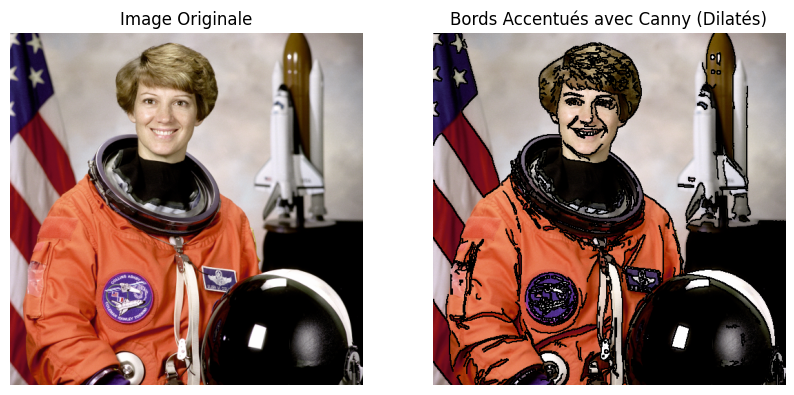

In [10]:
import cv2
import numpy as np
from skimage import data
import matplotlib.pyplot as plt

# Charger l'image de l'astronaute directement depuis scikit-image
image = data.astronaut()

# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Appliquer le filtre de Canny pour détecter les bords
edges = cv2.Canny(gray_image, 100, 200)

# Définir un noyau pour la dilatation
kernel_size = int(min(image.shape[0], image.shape[1]) * 0.005)  # 0,5% de la taille de l'image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Appliquer la dilatation pour augmenter la taille des bords
dilated_edges = cv2.dilate(edges, kernel)

# Créer une image RGB avec les bords dilatés
result = image.copy()
result[dilated_edges != 0] = [0, 0, 0]  # Colorer les bords en noir

# Afficher les images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title('Image Originale')
ax[0].axis('off')

ax[1].imshow(result)
ax[1].set_title('Bords Accentués avec Canny (Dilatés)')
ax[1].axis('off')

plt.show()

In [22]:
import torch
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict
from scipy.spatial.distance import hamming, cosine
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
from tqdm import tqdm

@dataclass
class EvaluateMetricConfig:
    metrics: List[str] = ("hamming", "cosine", "bleu")
    batch_size: int = 32
    num_input_sequences: int = 100  # Nombre de séquences d'entrée à utiliser
    sequence_length: int = 50
    vocab: str = None  # Sera déterminé automatiquement
    output_file: str = "evaluation_results.csv"

class EvaluateMetric:
    def __init__(self, config: EvaluateMetricConfig, models: Dict[str, torch.nn.Module], dataloader: torch.utils.data.DataLoader):
        self.config = config
        self.models = models
        self.dataloader = dataloader
        self.vocab = self._determine_vocab()
        self.metric_funcs = {
            "edit": self._edit_distance,
            "hamming": self._hamming_distance,
            "cosine": self._cosine_distance,
            "bleu": self._bleu_score,
        }

    def evaluate(self) -> pd.DataFrame:
        input_sequences = self._get_input_sequences()
        results = {}

        for model_name, model in self.models.items():
            print(f"Evaluating model: {model_name}")
            generated_sequences = self._generate_sequences(model, input_sequences)
            model_results = self._evaluate_sequences(generated_sequences, input_sequences)
            results[model_name] = model_results

        df = pd.DataFrame(results).T
        df.to_csv(self.config.output_file)
        print(f"Results saved to {self.config.output_file}")
        return df

    def _evaluate_sequences(self, generated_sequences: List[str], input_sequences: List[str]) -> Dict[str, float]:
        results = {}
        for metric in self.config.metrics:
            scores = [
                [self.metric_funcs[metric](input_seq, gen_seq) for input_seq in input_sequences]
                for gen_seq in generated_sequences
            ]
            results[f"{metric}_min"] = np.min(scores)
            results[f"{metric}_avg"] = np.mean(scores)
            results[f"{metric}_max"] = np.max(scores)
        return results


    # Méthodes de calcul des métriques
    def _edit_distance(self, seq1: str, seq2: str) -> float:
        return sum(c1 != c2 for c1, c2 in zip(seq1, seq2)) / max(len(seq1), len(seq2))

    def _hamming_distance(self, seq1: str, seq2: str) -> float:
        return hamming(list(seq1), list(seq2))

    def _cosine_distance(self, seq1: str, seq2: str) -> float:
        vec1, vec2 = Counter(seq1), Counter(seq2)
        keys = set(vec1.keys()) | set(vec2.keys())
        vec1 = [vec1.get(k, 0) for k in keys]
        vec2 = [vec2.get(k, 0) for k in keys]
        return cosine(vec1, vec2)

    def _bleu_score(self, seq1: str, seq2: str) -> float:
        return sentence_bleu([list(seq1)], list(seq2))